## Perturbation of sequences
### Dataset: HEV ORF1 Sequences of Human only
### Number of sequences = 698
### Max Seq Length = 2481
### Model: Transformer

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python310.zip',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/lib-dynload',
 '',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/..']

In [2]:
from models.nlp.transformer import transformer, transformer_model
from models.nlp import lstm, cnn1d
from datasets.protein_sequence_dataset import ProteinSequenceDataset
from utils import utils, nn_utils, visualization_utils
from models.nlp.embedding.padding import Padding
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
cmap = sns.color_palette("vlag", as_cmap=True)


from Bio import SeqIO
from Bio.Seq import Seq
from Bio import motifs


In [3]:
input_file_path = "/home/grads/blessyantony/dev/git/zoonosis/input/data/hev/aligned/hev_orf1_alignment_ba.fasta_processed.csv"
output_dir = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/hev/20231017/perturbed_dataset_prediction/orf1-aligned/transformer-l_6-h_8-lr1e-4/processed"
model_path = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/hev/20231012/host_multi_e50/orf1/transformer-l_6-h_8-lr1e-4-orf1_itr0.pth"


hev_df = pd.read_csv(input_file_path)

label_groupings = {
                    "Human": [ "Human" ],
                    "Boar": [ "Boar" ],
                    "Others": [ "*" ]
                }

amino_acid_idx_map = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5,
                  'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
                  'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
                  'O': 16, 'S': 17, 'U': 18, 'T': 19, 'W': 20,
                  'Y': 21, 'V': 22, 'B': 23, 'Z': 24, 'X': 25,
                  'J': 26, "-": 0}

idx_amino_acid_map = {v:k for k,v in amino_acid_idx_map.items()}
id_col = "id"
test_sequence_settings =  {
    "sequence_col": "sequence",
    "batch_size": 1,
    "max_sequence_length": 2481,
    "pad_sequence_val": 0,
    "truncate": True,
    "feature_type": "token"
}


label_settings = {
    "label_col": "host",
    "exclude_labels": [ "nan"],
    "label_groupings":  label_groupings
}

model = {
    "max_seq_len": 2481,
    "loss": "CrossEntropyLoss",
    "with_convolution": False,
    "n_heads": 8,
    "depth": 6,
    "n_tokens": 27,
    "n_classes": 3,
    "n_epochs": 10,
    "input_dim": 512, # input embedding dimension
    "hidden_dim": 1024
}

def post_plot_config():
    plt.rcParams['figure.autolayout'] = True
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 8

In [4]:
hev_df

,id,region,host,genotype,host-genotype,sequence
0,QJQ50412.1,ORF1,Avian,unknown,Avian-unknown,-MDVSQFAESKGVKTALEAAALAAANTALRNARVVTPYLTQQQTKN...
1,UNQ84074.1,ORF1,Avian,unknown,Avian-unknown,-MDVSQFAESKGVKTALEAAALAAANTALRNARVVTPYLTQQQTKN...
2,AAS45830.1,ORF1,Avian,unknown,Avian-unknown,-MDVSQFAESKGVKTALEAAALAAANTALRNARVVTPYLTQQQTKN...
3,YP_009001465.1,ORF1,Avian,unknown,Avian-unknown,-MDVSQFAESKGVKTALEAAALAAANTALRNARVVTPYLTQQQTKN...
4,UFQ90535.1,ORF1,Avian,unknown,Avian-unknown,-MDVSQFAESKGVKTALEAAALAAANTALRNARVVTPYLTQQQTKN...
...,...,...,...,...,...,...
949,AAA45732.1,ORF1,Unknown,HEV2,Unknown-HEV2,----------------------------------------------...
950,AAA45736.1,ORF1,Unknown,HEV1,Unknown-HEV1,----------------------------------------------...
951,AAS45831.1,ORF1,Avian,unknown,Avian-unknown,----------------------------------------------...
952,YP_009001467.1,ORF1,Avian,unknown,Avian-unknown,----------------------------------------------...


In [5]:
hev_human_df = hev_df[hev_df["host"] == "Human"]
hev_human_df

,id,region,host,genotype,host-genotype,sequence
14,BAD74175.1,ORF1,Human,HEV3,Human-HEV3,-MEAHQFIKAPGITTAIEQAALAAANSALANAVVVRPFLSRVQTEI...
15,BAD74178.1,ORF1,Human,HEV3,Human-HEV3,-MEAHQFIKAPGITTAIEQAALAAANSALANAVVVRPFLSRVQTEI...
17,BAD74181.1,ORF1,Human,HEV3,Human-HEV3,-MEAHQFIKAPGITTAIEQAALAAANSALANAVVVRPFLSRVQTEI...
18,BAD74172.1,ORF1,Human,HEV3,Human-HEV3,-MEAHQFIKAPGITTAIEQAALAAANSALANAVVVRPFLSRVQTEI...
19,BAG67055.1,ORF1,Human,HEV3,Human-HEV3,-MEAHQFIKAPGITTAIEQAALAAANSALANAVVVRPFLSRVQTEI...
...,...,...,...,...,...,...
914,QAU19544.1,ORF1,Human,unknown,Human-unknown,-METHQYVAATGVNTAREAQATAAAATAFANAQVVRPYLSHSQASL...
917,QEV82316.1,ORF1,Human,unknown,Human-unknown,-METHQYVAATGVNTAREAQATAAAATAFANAQVVRPYLSHSQASL...
919,QEV82319.1,ORF1,Human,unknown,Human-unknown,-METHQYVAATGVNTAREAQATAAAATAFANAQVVRPYLSHSQASL...
920,QEV82325.1,ORF1,Human,unknown,Human-unknown,-METHQYVAATGVNTAREAQATAAAATAFANAQVVRPYLSHSQASL...


In [6]:
def get_token_dataset_loader(df, sequence_settings, label_settings):
    label_col = label_settings["label_col"]
    
    seq_col = sequence_settings["sequence_col"]
    batch_size = sequence_settings["batch_size"]
    max_seq_len = sequence_settings["max_sequence_length"]
    pad_sequence_val = sequence_settings["pad_sequence_val"]
    truncate = sequence_settings["truncate"]
    
    df = df[[seq_col, label_col]]
    df, index_label_map = utils.transform_labels(df, label_settings, classification_type="multi")

    dataset = ProteinSequenceDataset(df, seq_col, max_seq_len, truncate, label_col)
    return index_label_map, DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True,
                      collate_fn=Padding(max_seq_len, pad_sequence_val))


def get_dataset_loader_for_seq(genbank_id):
    id_df = hev_human_df[hev_human_df["id"] == genbank_id]
    index_label_map, dataset_loader =  get_token_dataset_loader(id_df, test_sequence_settings, label_settings)
    return id_df, index_label_map, dataset_loader

def get_aligned_seq(genbank_id):
    aligned_seq_row = hev_human_df[hev_human_df["id"] == genbank_id]
    aligned_seq = aligned_seq_row["seq"].values[0]
    aligned_token_count = aligned_seq_row["aligned_token_count"].values[0]
    return aligned_seq, aligned_token_count

### Load the model

In [7]:
tf_custom_model = transformer.get_transformer_model(model)
tf_custom_model.load_state_dict(torch.load(model_path))
tf_custom_model = tf_custom_model.to(nn_utils.get_device())
tf_custom_model.eval()
tf_custom_model.zero_grad()

Transformer(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(27, 512)
    (positional_embedding): PositionalEncoding()
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
          (W_O): Linear(in_features=512, out_features=512, bias=True)
        )
        (feed_forward): FeedForwardLayer(
          (W_1): Linear(in_features=512, out_features=1024, bias=True)
          (W_2): Linear(in_features=1024, out_features=512, bias=True)
        )
        (residual_connections): ModuleList(
          (0-1): 2 x ResidualConnectionLayer(
            (norm): NormalizationLayer()
          )
        )
      )
    )
    (norm): NormalizationLayer()
  )
  (linear): Linear(in_features=512, out_features=3, b

In [8]:
def validate(model, dataset_loader, index_label_map):
    with torch.no_grad():
        model.eval()

        results = []

        for _, data in enumerate(dataset_loader):
            # get input and labels; data is a list of [(inputs, labels)]
            inputs, labels = data

            output = model(inputs)

            # tensorboard + logs

            # to get probabilities of the output
            output = F.softmax(output, dim=-1)
            result_df = pd.DataFrame(output.cpu().numpy())
            result_df.rename(columns=index_label_map, inplace=True)
            result_df["y_true"] = labels.cpu().numpy()
            result_df["y_true"] = result_df["y_true"].map(index_label_map)
            
            results.append(result_df)
    
    return inputs, pd.concat(results, ignore_index=True)

In [9]:
def get_aligned_seq_pos_mapping(seq):
    aligned_seq_pos_map = {}
    token_count = 0
    for i, token in enumerate(seq):
        if token == "-":
            aligned_seq_pos_map[i] = 0
        else:
            token_count += 1
            aligned_seq_pos_map[i] = token_count
    return aligned_seq_pos_map

In [14]:
output_files = os.listdir(output_dir)
print(f"Number of perturbed output files = {len(output_files)}")

error_genbank_ids = []
diff_dfs = []
for output_file in output_files:
    regex_result = re.search(r"tf\_hev\_orf1\_alignment\_ba\.fasta\_processed\.csv\_([A-Z0-9\.]+)\.csv", output_file)
    genbank_id = regex_result.group(1)
    try:
        genbank_id_df, index_label_map, dataset_loader = get_dataset_loader_for_seq(genbank_id)
    except:
        error_genbank_ids.append(genbank_id)
        continue
    
    inputs, output_df = validate(tf_custom_model, dataset_loader, index_label_map)
    perturbed_output_df = pd.read_csv(os.path.join(output_dir, output_file))
    orig_seq = genbank_id_df["sequence"].values[0]
    aligned_seq_pos_map = get_aligned_seq_pos_mapping(orig_seq)
    orig_seq_human_pred = output_df["Human"].values[0]
    perturbed_output_df = perturbed_output_df[["Human", "id", "orig_token", "perturb_pos", "new_token"]]
    perturbed_output_df["seq_pos"] = perturbed_output_df["perturb_pos"].apply(lambda x: aligned_seq_pos_map[x])
    perturbed_output_df["pred_diff"] = perturbed_output_df["Human"] - orig_seq_human_pred
    pivot_df = perturbed_output_df.pivot(columns="seq_pos", index="new_token", values="pred_diff")
    diff_dfs.append(pivot_df)
    
print(f"ERROR GenBankIds = {error_genbank_ids}")

Number of perturbed output files = 514
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Bo

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}
ERROR GenBankIds = ['AXL93753.1', 'AOG18217.1', 'BAV53288.1', 'QBP05413.1', 'AXB26865.1', 'BAF65205.1', 'BDB30815.1', 'AOG18220.1', 'AUM59992.1', 'ART85723.1', 'AYA00978.1', 'AKQ44212.1', 'AZC85747.1', 'APA34844.1', 'AUR34020.1', 'QOH99466.1', 'QBP05410.1', 'AAM92182.1', 'UNQ84074.1', 'BAE48647.1', 'UBR08171.1', 'BAE48650.1', 'BAM78544.1', 'BAG67067.1', 'AYA58356.1', 'BAH03571.1', 'BAL61209.1', 'BAE92012.1', 'AAC97208.1', 'AZC85753.1', 'QJQ50412.1', 'UFQ90535.1', 'BAD74169.1', 'BAE48653.1', 'BBL78144.1', 'BAK08878.1', 'AZC85750.1', 'ASL05061.1', 'AYA00975.1', 'UBR27789.1', 'AZC85741.1', 'BAV53291.1', 'BAH03565.1', 'AZC85735.1', 'QAT90245.1', 'BBA54718.1', 'QLM05487.1', 'USE40368.1', 'AZC85759.1', 'AZC85738.1', 'AQY45719.1', 'AFR53968.1', 'AUM59989.1', 'BBF24301.1', 'AOG18211.1', 'BAH03559.1', 'USE571

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [15]:
perturbed_output_df

,Human,id,orig_token,perturb_pos,new_token,seq_pos,pred_diff
0,0.462939,QSD98982.1,F,809,I,694,0.000017
1,0.462888,QSD98982.1,L,62,Y,62,-0.000034
2,0.462971,QSD98982.1,R,2058,S,1305,0.000049
3,0.462965,QSD98982.1,V,130,A,115,0.000043
4,0.462952,QSD98982.1,V,2425,K,1653,0.000031
...,...,...,...,...,...,...,...
42571,0.462897,QSD98982.1,S,795,M,683,-0.000025
42572,0.462927,QSD98982.1,N,691,R,624,0.000006
42573,0.462871,QSD98982.1,P,1167,U,759,-0.000051
42574,0.462926,QSD98982.1,Q,1847,C,1114,0.000004


In [16]:
def print_histogram(values, n_bins=12):
    n = len(values)
    freq, bins = np.histogram(values, bins=n_bins)
    hist_map = []
    for i in range(n_bins):
        hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})


    hist_df = pd.DataFrame(hist_map)
    print(hist_df.head(20))

In [17]:
df = perturbed_output_df.pivot(columns="seq_pos", index="new_token", values="pred_diff")
# remove B, Z, X, J perturbations
mod_df = df.drop(index=["B", "Z", "X", "J"])
mod_df

seq_pos,1,2,3,4,5,6,7,8,9,10,...,1694,1695,1696,1697,1698,1699,1700,1701,1702,1703
new_token,,,,,,,,,,,,,,,,,,,,,
A,2.866920e-05,1.695920e-05,NaN,6.529201e-06,1.433920e-05,2.298920e-05,8.389201e-06,1.030920e-05,NaN,7.359201e-06,...,4.889201e-06,4.529201e-06,0.000025,-0.000016,1.480920e-05,1.623920e-05,1.880920e-05,0.000035,3.648920e-05,1.725920e-05
C,1.745920e-05,6.439201e-06,-0.000009,8.920097e-08,1.111920e-05,2.044920e-05,3.929201e-06,2.289201e-06,-1.115080e-05,-5.630799e-06,...,-6.940799e-06,-8.280799e-06,0.000012,-0.000027,3.609201e-06,5.089201e-06,6.739201e-06,0.000022,2.294920e-05,4.529201e-06
D,2.892010e-07,-1.801080e-05,-0.000037,-2.566080e-05,-1.181080e-05,3.892010e-07,-1.314080e-05,-1.121080e-05,-2.187080e-05,-1.457080e-05,...,-4.569080e-05,-4.056080e-05,-0.000015,-0.000052,-2.281080e-05,-2.911080e-05,-3.811080e-05,-0.000029,-2.488080e-05,-3.609080e-05
E,1.308920e-05,NaN,-0.000017,-9.570799e-06,2.092010e-07,1.030920e-05,-3.190799e-06,-1.040799e-06,-1.195080e-05,-5.480799e-06,...,-1.237080e-05,-1.186080e-05,0.000009,-0.000031,-3.307990e-07,7.492010e-07,2.029201e-06,0.000017,1.880920e-05,NaN
F,2.389201e-06,-1.451080e-05,-0.000032,-2.167080e-05,-1.043080e-05,NaN,-1.351080e-05,-1.115080e-05,-2.146080e-05,-1.356080e-05,...,-2.626080e-05,-2.658080e-05,-0.000003,-0.000039,-6.940799e-06,-5.160799e-06,-4.610799e-06,0.000010,1.045920e-05,-7.870799e-06
G,1.573920e-05,3.249201e-06,-0.000013,-5.630799e-06,4.289201e-06,1.394920e-05,-9.107990e-07,-1.079903e-08,-1.144080e-05,-5.010799e-06,...,-7.060799e-06,-7.570799e-06,0.000013,-0.000027,3.159201e-06,4.529201e-06,6.939201e-06,0.000023,2.446920e-05,5.309201e-06
H,2.583920e-05,1.346920e-05,-0.000005,NaN,8.259201e-06,1.865920e-05,6.829201e-06,1.060920e-05,7.492010e-07,6.829201e-06,...,-1.640799e-06,-1.410799e-06,0.000020,-0.000020,1.152920e-05,1.408920e-05,1.725920e-05,0.000033,3.382920e-05,1.308920e-05
I,1.458920e-05,8.092010e-07,-0.000016,-7.570799e-06,3.789201e-06,1.450920e-05,NaN,2.392010e-07,-1.165080e-05,-5.410799e-06,...,-1.356080e-05,-1.258080e-05,0.000009,-0.000030,NaN,NaN,-1.507990e-07,0.000014,1.558920e-05,-1.910799e-06
K,1.465920e-05,1.589201e-06,-0.000016,-8.710799e-06,9.192010e-07,1.102920e-05,-2.260799e-06,NaN,-1.064080e-05,-4.210799e-06,...,-8.910799e-06,-8.710799e-06,0.000012,-0.000027,3.819201e-06,5.089201e-06,6.229201e-06,0.000020,2.098920e-05,2.149201e-06


<Figure size 640x480 with 0 Axes>

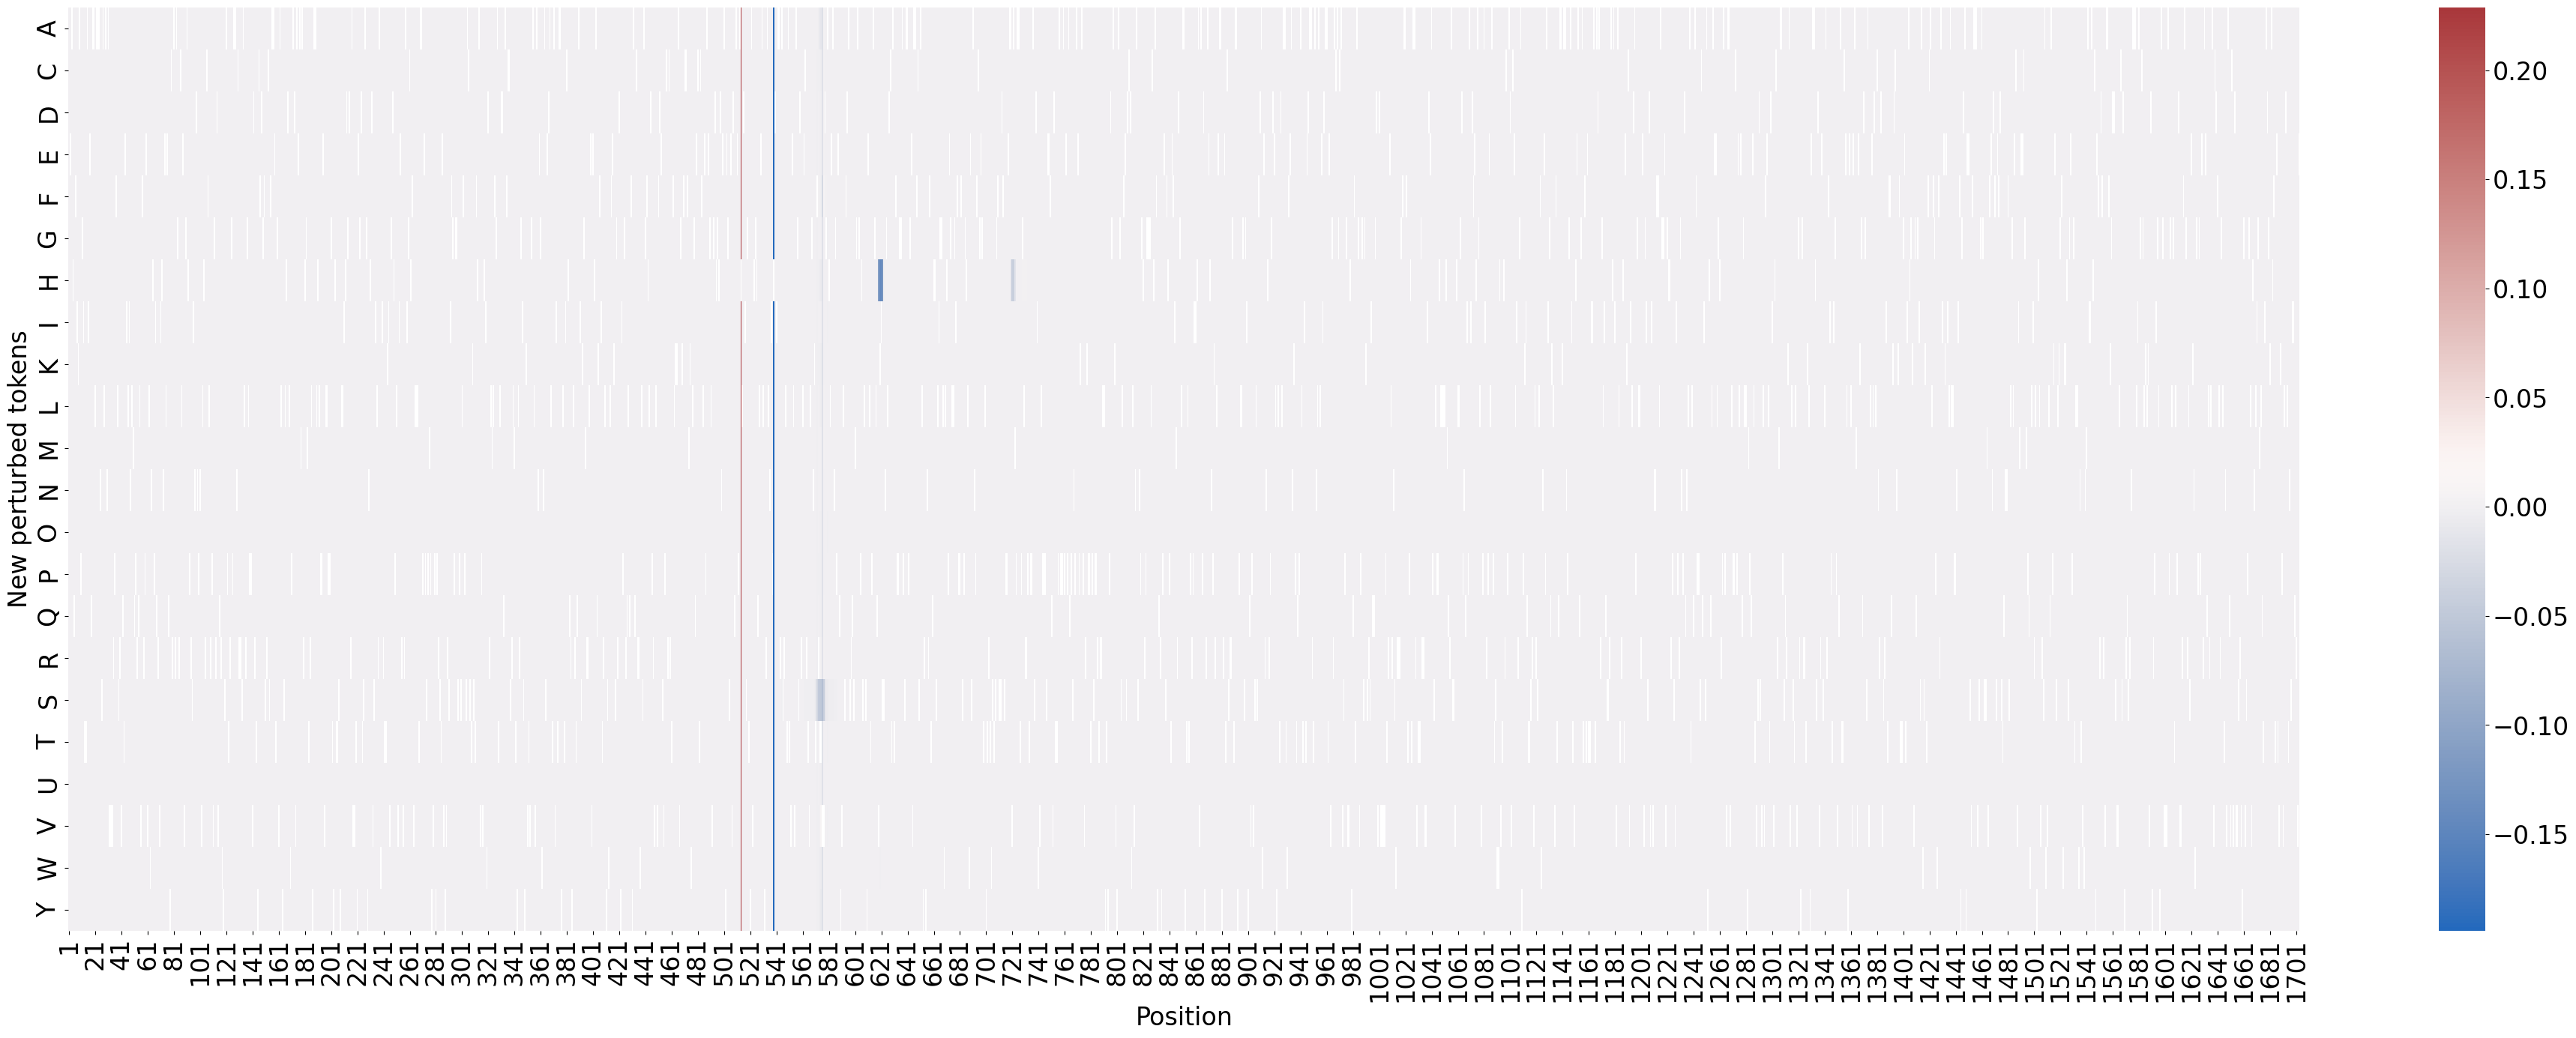

In [20]:
# visualization_utils.pre_plot_config(figsize=(40, 20))
plt.clf()
plt.figure(figsize=(48, 16))
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
ax = sns.heatmap(mod_df, cmap=cmap)
# plt.rcParams['figure.autolayout'] = True
plt.xlabel('Position', fontsize=24)
plt.ylabel('New perturbed tokens', fontsize=24)
plt.show()

<Figure size 640x480 with 0 Axes>

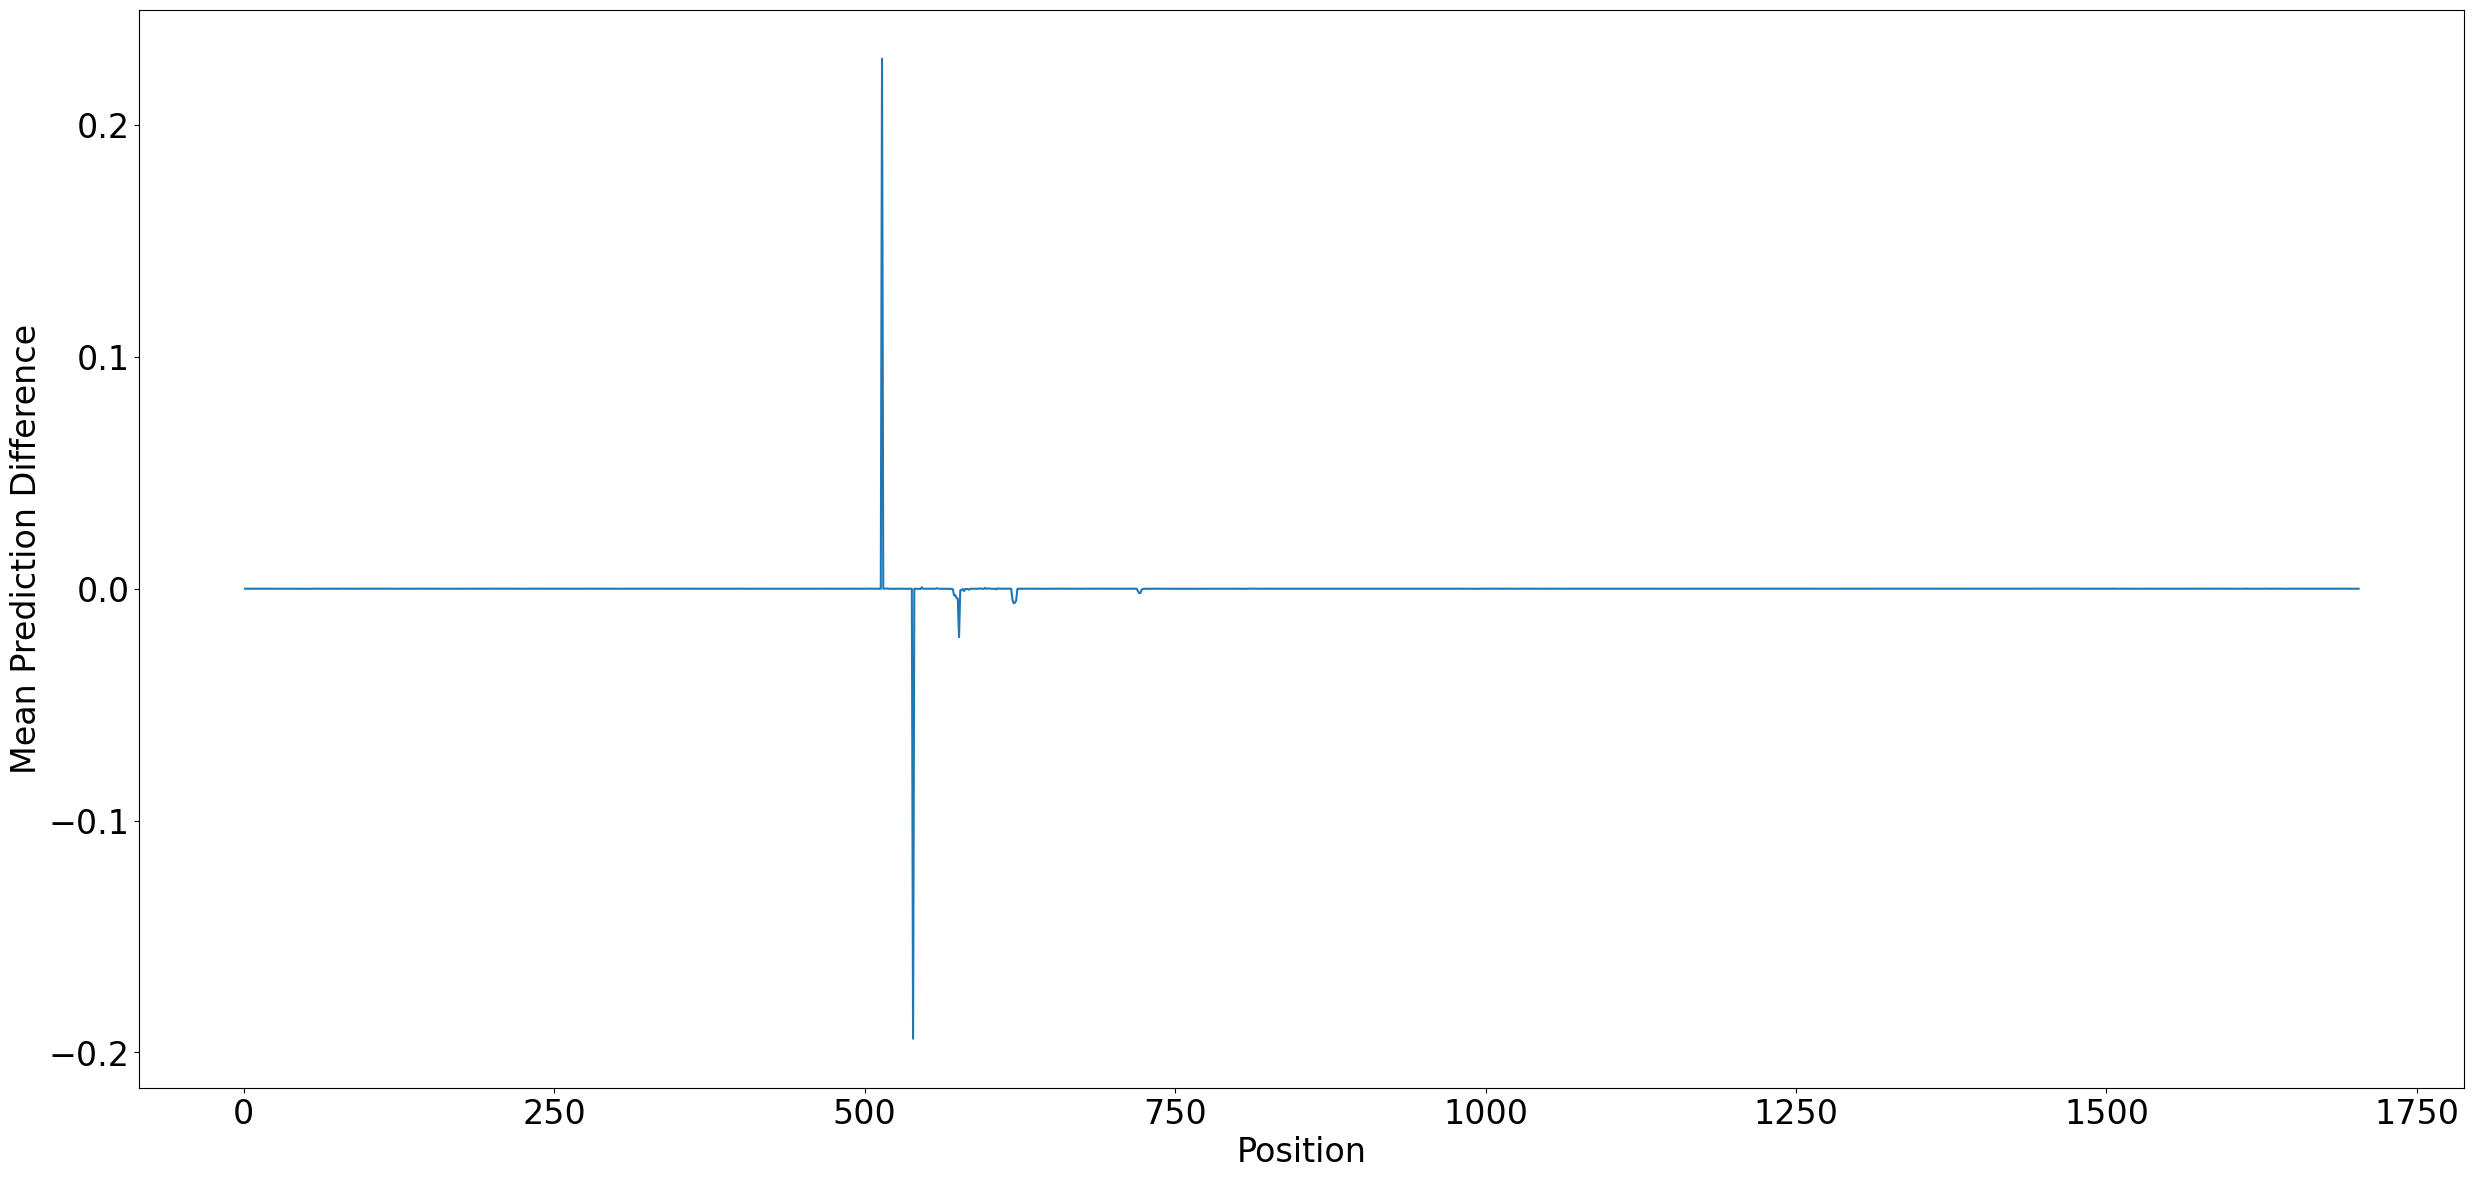

In [42]:
plt.clf()
plt.figure(figsize=(30, 14))
ax = sns.lineplot(df.mean(axis=0))
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.xlabel('Position', fontsize=24)
plt.ylabel('Mean Prediction Difference', fontsize=24)

plt.show()

In [43]:
mod_df.mean(axis=0)

seq_pos
1       1.378966e-05
2       8.111057e-07
3      -1.740937e-05
4      -9.322228e-06
5       8.963438e-07
            ...     
1699    6.587248e-07
1700    1.592058e-06
1701    1.672777e-05
1702    1.773730e-05
1703   -1.823656e-06
Length: 1703, dtype: float64

In [44]:
print_histogram(perturbed_output_df["pred_diff"])

       start       end  count  percentage
0  -0.194189 -0.158942     25    0.058719
1  -0.158942 -0.123694      3    0.007046
2  -0.123694 -0.088446      1    0.002349
3  -0.088446 -0.053198      1    0.002349
4  -0.053198 -0.017950     31    0.072811
5  -0.017950  0.017297  42490   99.798008
6   0.017297  0.052545      0    0.000000
7   0.052545  0.087793      0    0.000000
8   0.087793  0.123041      0    0.000000
9   0.123041  0.158289      0    0.000000
10  0.158289  0.193537      0    0.000000
11  0.193537  0.228784     25    0.058719


### Identify important position across all sequences

In [45]:
mean_diff_dfs = [x_df.mean(axis=0) for x_df in diff_dfs]

In [46]:
mean_diff_df = pd.DataFrame(mean_diff_dfs)
mean_diff_df

seq_pos,1,2,3,4,5,6,7,8,9,10,...,1774,1775,1776,1777,1778,1779,1780,1781,1782,1783
0,1.275578e-05,-1.209124e-06,-0.000019,-0.000011,5.132760e-07,0.000010,-0.000003,-0.000002,-0.000014,-6.095124e-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1.592343e-05,-2.123280e-06,-0.000020,-0.000030,-8.569280e-06,-0.000011,-0.000011,-0.000002,-0.000018,-1.402448e-05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6.256059e-08,-1.345176e-05,-0.000030,0.000056,5.071438e-06,-0.000005,-0.000007,0.000022,-0.000021,3.343751e-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.358858e-05,-9.232193e-06,-0.000032,0.000049,2.836207e-06,0.000005,-0.000018,0.000019,-0.000025,-5.894193e-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.256053e-05,-1.214650e-06,-0.000019,-0.000010,3.241503e-07,0.000010,-0.000004,-0.000002,-0.000014,-6.507450e-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,1.266597e-05,-1.714879e-06,-0.000019,-0.000010,1.154721e-06,0.000009,-0.000003,-0.000002,-0.000014,-6.158079e-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
427,1.247647e-05,-1.949822e-06,-0.000019,-0.000010,9.677783e-07,0.000009,-0.000003,-0.000002,-0.000014,-6.193822e-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
428,-1.196569e-05,-1.370106e-05,-0.000032,-0.000006,-9.628660e-06,-0.000021,-0.000007,0.000010,-0.000030,-8.909860e-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
429,1.140278e-07,-1.324076e-05,-0.000030,0.000058,4.850443e-06,-0.000005,-0.000007,0.000022,-0.000022,-5.595681e-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# retain only columns with respect to a randomly selected aligned sequence
token_cols = perturbed_output_df["perturb_pos"].unique()
print(len(token_cols))
token_cols.sort()
token_cols

1703


array([   1,    2,    3, ..., 2478, 2479, 2480])

In [48]:
# mean_diff_df = mean_diff_df[token_cols]
# # remap the columns from pertrbation position to actual sequence position w.r.t wiv04
# mean_diff_df.columns = list(token_cols)
# mean_diff_df.shape

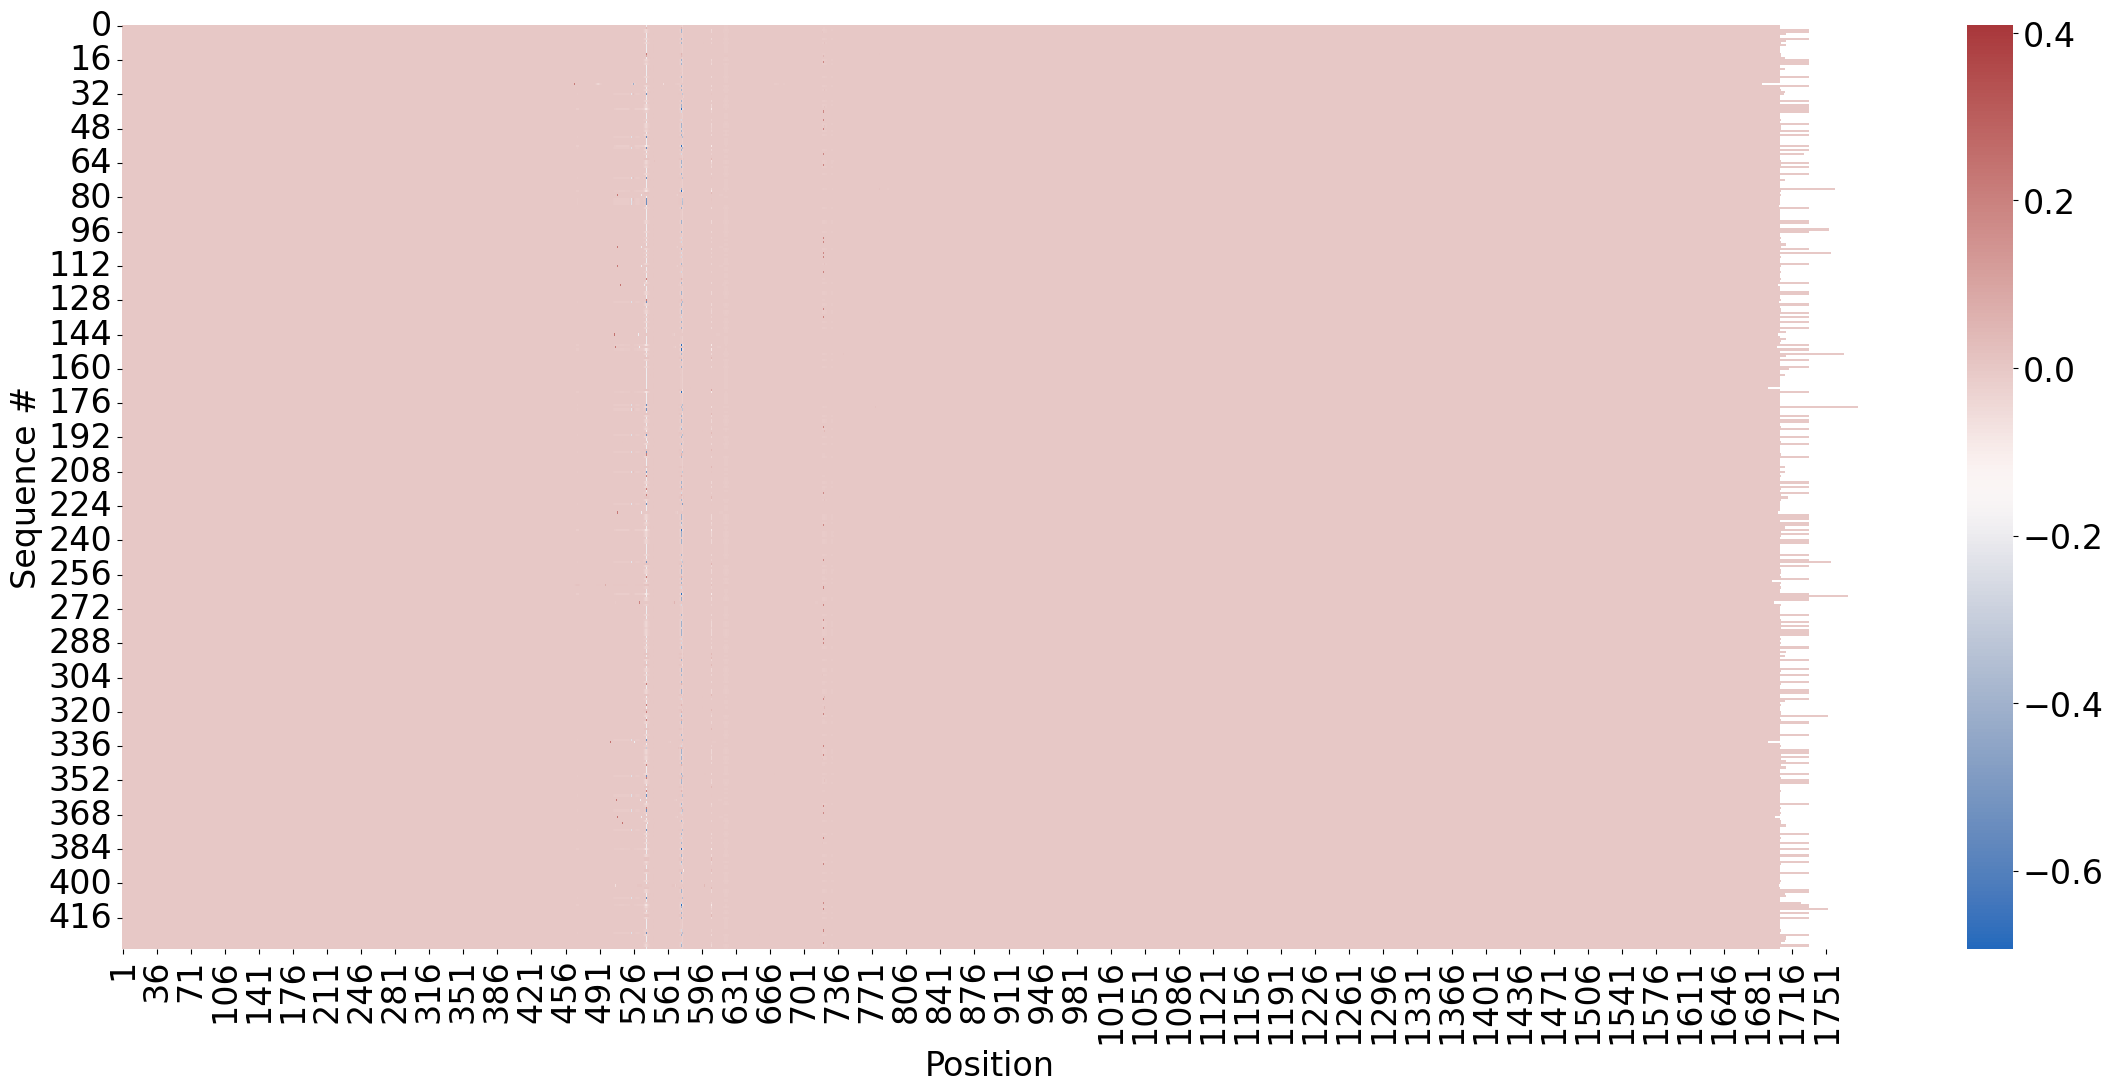

In [49]:
plt.figure(figsize=(28,12))
sns.heatmap(mean_diff_df, cmap=cmap)
plt.xlabel('Position', fontsize=24)
plt.ylabel('Sequence #', fontsize=24)
plt.show()

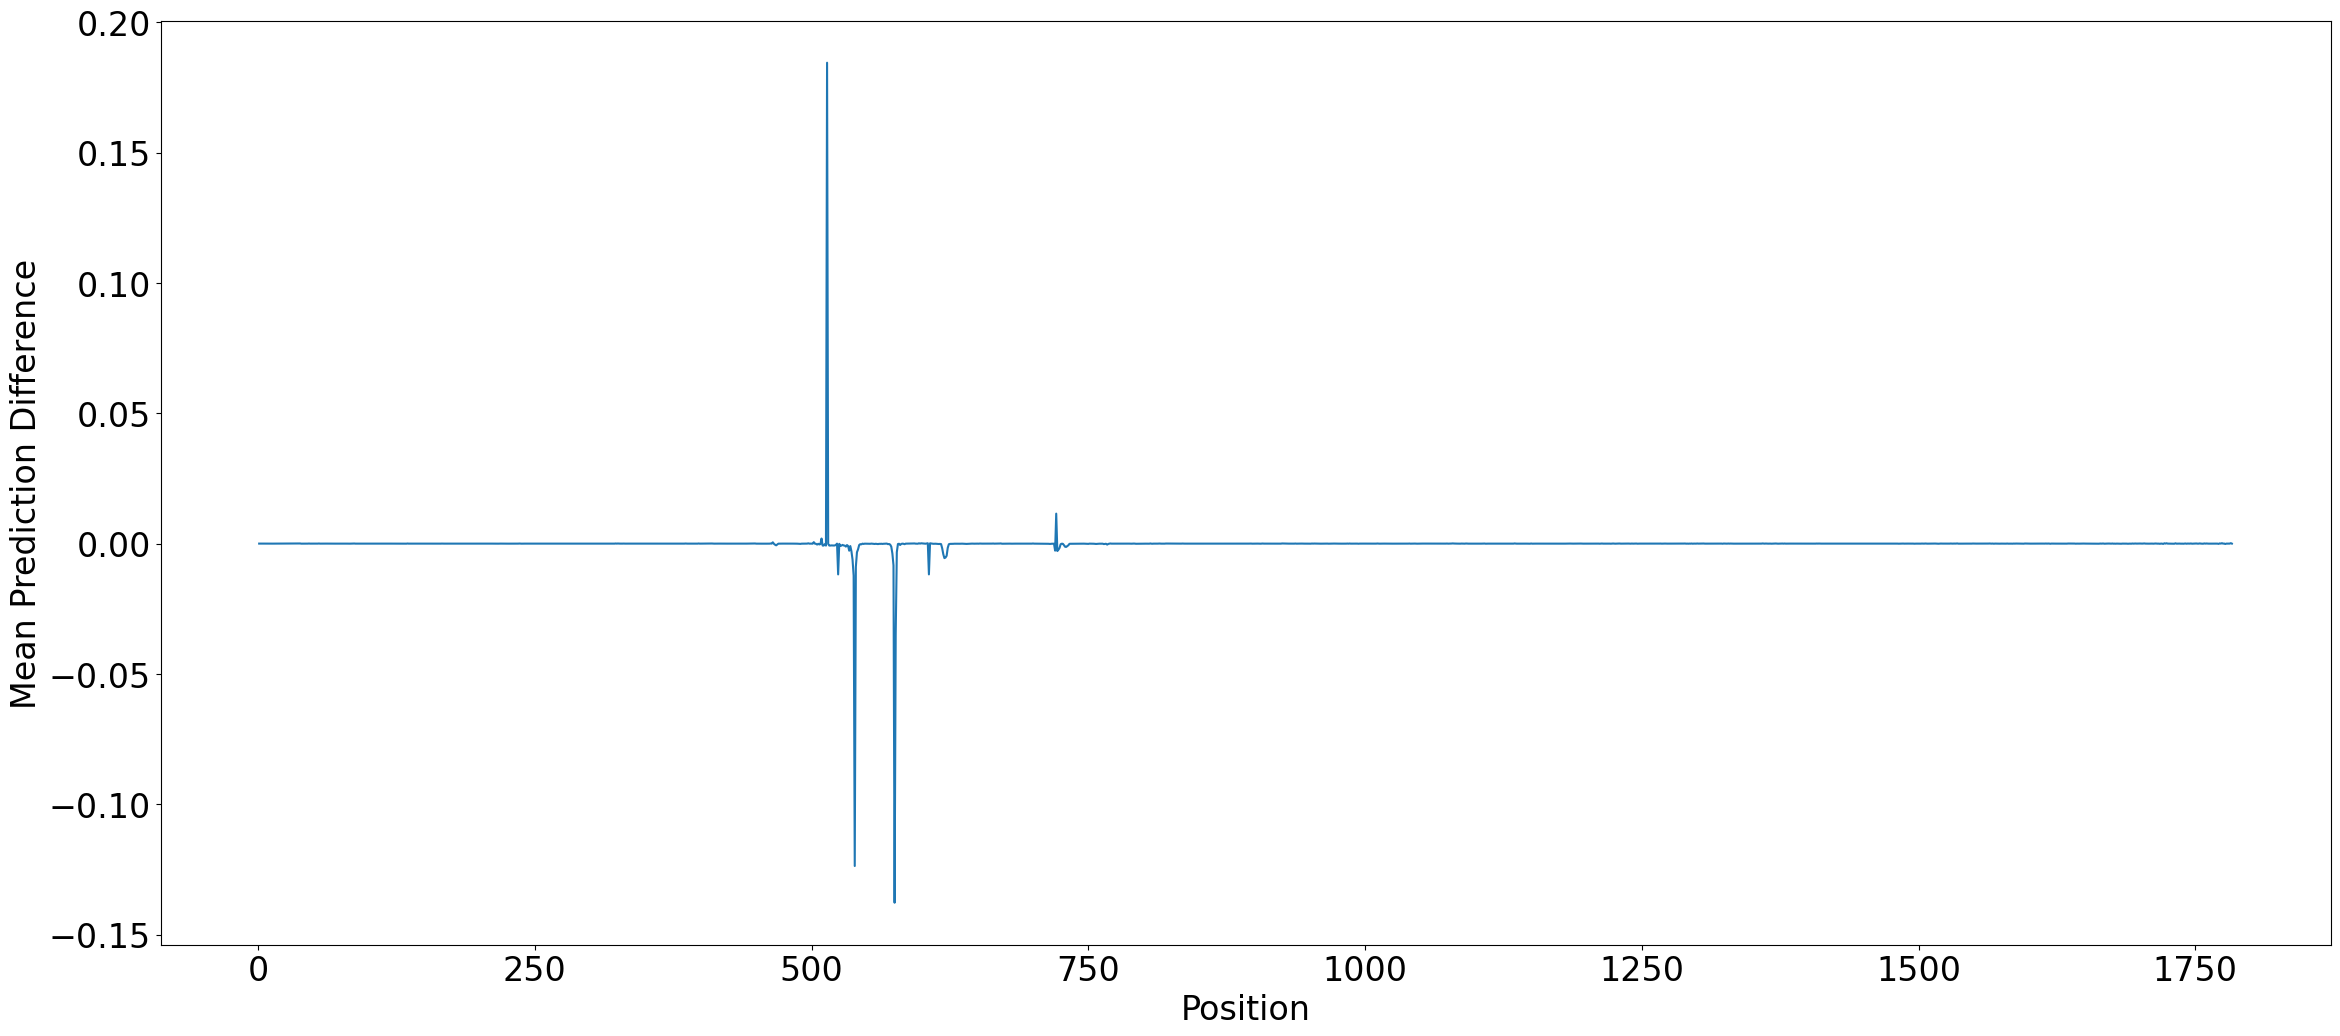

In [50]:
plt.figure(figsize=(28,12))
sns.lineplot(mean_diff_df.mean(axis=0))
plt.xlabel('Position', fontsize=24)
plt.ylabel('Mean Prediction Difference', fontsize=24)
plt.show()

In [51]:
mean_diff_df.mean(axis=0).nsmallest(10)

seq_pos
575   -0.137741
539   -0.123656
576   -0.034699
538   -0.012272
524   -0.011810
606   -0.011806
540   -0.008866
574   -0.008338
537   -0.006117
620   -0.005569
dtype: float64

In [53]:
mean_diff_df.mean(axis=0).nlargest(10)

seq_pos
514     0.184455
721     0.011500
509     0.001959
502     0.000552
465     0.000505
1782    0.000175
1774    0.000168
605     0.000144
1724    0.000132
1722    0.000130
dtype: float64

In [52]:
print_histogram(mean_diff_df.mean(axis=0))

       start       end  count  percentage
0  -0.137741 -0.110891      2    0.112170
1  -0.110891 -0.084041      0    0.000000
2  -0.084041 -0.057192      0    0.000000
3  -0.057192 -0.030342      1    0.056085
4  -0.030342 -0.003493     11    0.616938
5  -0.003493  0.023357   1768   99.158721
6   0.023357  0.050207      0    0.000000
7   0.050207  0.077056      0    0.000000
8   0.077056  0.103906      0    0.000000
9   0.103906  0.130755      0    0.000000
10  0.130755  0.157605      0    0.000000
11  0.157605  0.184455      1    0.056085
